<a href="https://colab.research.google.com/github/bahador1/BahadorColabNotes/blob/main/dlg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import pickle
import PIL.Image as Image

In [7]:
class LeNet(nn.Module):
    def __init__(self, channel=3, hideen=768, num_classes=10):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(channel, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(hideen, num_classes)
        )

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


def weights_init(m):
    try:
        if hasattr(m, "weight"):
            m.weight.data.uniform_(-0.5, 0.5)
    except Exception:
        print('warning: failed in weights_init for %s.weight' % m._get_name())
    try:
        if hasattr(m, "bias"):
            m.bias.data.uniform_(-0.5, 0.5)
    except Exception:
        print('warning: failed in weights_init for %s.bias' % m._get_name())


In [8]:
class Dataset_from_Image(Dataset):
    def __init__(self, imgs, labs, transform=None):
        self.imgs = imgs # img paths
        self.labs = labs # labs is ndarray
        self.transform = transform
        del imgs, labs

    def __len__(self):
        return self.labs.shape[0]

    def __getitem__(self, idx):
        lab = self.labs[idx]
        img = Image.open(self.imgs[idx])
        if img.mode != 'RGB':
            img = img.convert('RGB')
        img = self.transform(img)
        return img, lab



In [9]:
# def main():
dataset = 'MNIST'
root_path = '.'
data_path = os.path.join(root_path, '../data').replace('\\', '/')
save_path = os.path.join(root_path, 'results/iDLG_%s'%dataset).replace('\\', '/')

# lr = 1.0
num_dummy = 1
# num_exp = 1000

use_cuda = torch.cuda.is_available()
device = 'cuda' if use_cuda else 'cpu'

tt = transforms.Compose([transforms.ToTensor()])
tp = transforms.Compose([transforms.ToPILImage()])

print(dataset, 'root_path:', root_path)
print(dataset, 'data_path:', data_path)
print(dataset, 'save_path:', save_path)

if not os.path.exists('results'):
    os.mkdir('results')
if not os.path.exists(save_path):
    os.mkdir(save_path)



''' load data '''
if dataset == 'MNIST':
    shape_img = (28, 28)
    num_classes = 10
    channel = 1
    hidden = 588
    dst = datasets.MNIST(data_path, download=True)

MNIST root_path: .
MNIST data_path: ./../data
MNIST save_path: ./results/iDLG_MNIST


100%|██████████| 9.91M/9.91M [00:00<00:00, 56.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.71MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.5MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.41MB/s]


In [10]:
''' train DLG and iDLG '''
# for idx_net in range(num_exp):
net = LeNet(channel=channel, hideen=hidden, num_classes=num_classes)
net.apply(weights_init)

net = net.to(device)

In [11]:
idx_shuffle = np.random.permutation(len(dst))

# for method in ['DLG', 'iDLG']:
method = 'DLG'
print('%s, Try to generate %d images' % (method, num_dummy))

DLG, Try to generate 1 images


In [12]:
imidx_list = []
for imidx in range(num_dummy):
    idx = idx_shuffle[imidx]
    imidx_list.append(idx)
    tmp_datum = tt(dst[idx][0]).float().to(device)
    tmp_datum = tmp_datum.view(1, *tmp_datum.size())
    tmp_label = torch.Tensor([dst[idx][1]]).long().to(device)
    tmp_label = tmp_label.view(1, )
    if imidx == 0:
        gt_data = tmp_datum
        gt_label = tmp_label
    # else:
    #     gt_data = torch.cat((gt_data, tmp_datum), dim=0)
    #     gt_label = torch.cat((gt_label, tmp_label), dim=0)

In [14]:
criterion = nn.CrossEntropyLoss().to(device)

#original Grad: forward pass
out = net(gt_data)
loss = criterion(out, gt_label)

#original Grad: backward phase
dloss_dx = torch.autograd.grad(loss , net.parameters())       # dloss(x, w)/ dw_i
original_dy_dx = list((_.detach().clone() for _ in dloss_dx)) # original gradient Tensors

# generate dummy data and label
dummy_data  = torch.randn(gt_data.size()).to(device).requires_grad_(True)
dummy_label = torch.randn((gt_data.shape[0], num_classes)).to(device).requires_grad_(True)

#this optimizer is for updating dummy data.
optimizer = torch.optim.LBFGS([dummy_data, dummy_label], lr=1.0, )

#point 1
history = []
history_iters = []
losses = []
mses = []
train_iters = []

Iteration = 300

jj = 0
for iters in range(Iteration):

    def closure():
        global jj
        print("internal iteration", jj)
        jj+=1
        optimizer.zero_grad()
        pred = net(dummy_data)
        # if method == 'DLG':
        dummy_loss = - torch.mean(torch.sum(torch.softmax(dummy_label, -1) * torch.log(torch.softmax(pred, -1)), dim=-1))
        # dummy_loss = criterion(pred, gt_label)

        dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)
        # print("dummy_dy_dw", torch.mean(dummy_dy_dx[0]))

        grad_diff = 0
        for gx, gy in zip(dummy_dy_dx, original_dy_dx):
            grad_diff += ((gx - gy) ** 2).sum()

        grad_diff.backward()
        return grad_diff

    optimizer.step(closure) # b sabke LBFGS
    current_loss = closure().item()
    train_iters.append(iters)
    losses.append(current_loss)
    mses.append(torch.mean((dummy_data-gt_data)**2).item())


    if False:#iters % int(Iteration / 30) == 0:
        current_time = str(time.strftime("[%Y-%m-%d %H:%M:%S]", time.localtime()))
        print(current_time, iters, 'D_i = %.8f, rec error = %.8f' %(current_loss, mses[-1]))
        history.append([tp(dummy_data[imidx].cpu()) for imidx in range(num_dummy)])
        history_iters.append(iters)

        for imidx in range(num_dummy):
            plt.figure(figsize=(12, 8))
            plt.subplot(3, 10, 1)
            plt.imshow(tp(gt_data[imidx].cpu()))
            for i in range(min(len(history), 29)):
                plt.subplot(3, 10, i + 2)
                plt.imshow(history[i][imidx])
                plt.title('iter=%d' % (history_iters[i]))
                plt.axis('off')
            if method == 'DLG':
                plt.savefig('%s/DLG_on_%s_%05dadam.png' % (save_path, imidx_list, imidx_list[imidx]))
                plt.close()


        if current_loss < 0.000001: # converge
            print("it has converged")
            break

if method == 'DLG':
    loss_DLG = losses
    label_DLG = torch.argmax(dummy_label, dim=-1).detach().item()
    mse_DLG = mses


print('imidx_list:', imidx_list)
print('loss_DLG D_i:', loss_DLG[-1],)
print('mse final x` and x :', mse_DLG[-1], )
# print('gt_label:', gt_label.detach().cpu().data.numpy(), 'lab_DLG:', label_DLG, )

print('----------------------\n\n')

internal iteration 0
internal iteration 1
internal iteration 2
internal iteration 3
internal iteration 4
imidx_list: [np.int64(6108)]
loss_DLG D_i: 100.37378692626953
mse final x` and x : 1.02446711063385
----------------------




### wtf is LBFGS

In [17]:
import torch
x = torch.tensor([0.], requires_grad=True)

In [18]:
optimizer = torch.optim.LBFGS([x], lr = 1, max_iter = 0)

In [19]:
def closure():
    optimizer.zero_grad()

    loss  = (x - 2)**2
    loss.backward()
    return loss


optimizer.step(closure)


tensor([4.], grad_fn=<PowBackward0>)

In [20]:
x

tensor([2.], requires_grad=True)

### 🧠 Example: Fitting a Curve


Epoch 1, Loss: 0.246098
Epoch 2, Loss: 0.032084
Epoch 3, Loss: 4.067127
Epoch 4, Loss: 0.073432
Epoch 5, Loss: 0.021823
Epoch 6, Loss: 0.011732
Epoch 7, Loss: 0.010619
Epoch 8, Loss: 0.010214
Epoch 9, Loss: 0.010084
Epoch 10, Loss: 0.010048


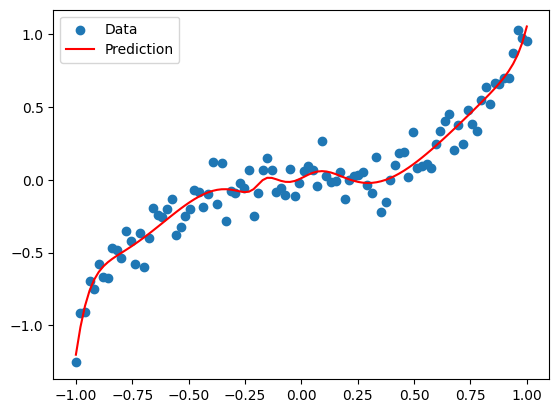

In [21]:
import torch
import matplotlib.pyplot as plt

# Generate sample data
x_train = torch.linspace(-1, 1, 100).unsqueeze(1)
y_train = x_train.pow(3) + 0.1 * torch.randn(x_train.size())

# Define model
model = torch.nn.Sequential(
    torch.nn.Linear(1, 10),
    torch.nn.Tanh(),
    torch.nn.Linear(10, 1)
)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.8)

def closure():
    optimizer.zero_grad()
    output = model(x_train)
    loss = criterion(output, y_train)
    loss.backward()
    return loss

# Run optimization
for epoch in range(10):
    loss = optimizer.step(closure)
    print(f'Epoch {epoch+1}, Loss: {loss.item():.6f}')

# Plot
predicted = model(x_train).detach()
plt.scatter(x_train.numpy(), y_train.numpy(), label='Data')
plt.plot(x_train.numpy(), predicted.numpy(), label='Prediction', color='red')
plt.legend()
plt.show()
